- Поменяли параметры генерации популяции

- Пока для скорости угадываем одну admixture, а не 7

- Поменяли способ подсчета векторов распределений - усредняем по всем репликациям

- Поменяли вариант репрезентации результатов: смотрим на оптимум функции на всей области $(0;1)$

- Нашли оптимальную функцию подсчета распределений

# Общее (Подготовка)

## Константы, объявления и неизменные части

In [150]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG, display
from scipy.optimize import minimize
import concurrent.futures
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

In [166]:
# константы
# размеры выборок


k_reference = 100
k_learning = 25
k_validation = 5
m = 1 # пока работаем с генерацией одной admixture, чтобы ускорять
# организмы будем делать гаплоидными.
ploidy = 1

# пропорция (она неизвестна, её ищем)
alpha = 0.2
# correct = [alpha*i for i in range(1, m+1)]
# параметры демографии
dem_size = 1e5
T_big_split = 1000
T_C = 200 # чтобы успели накопиться изменения

# параметры ARG
sequence_len=3e6
recomb_rate=1e-9 # надо 1e-8
replicates=100 # потребовалось, чтобы seq_len * num_repl >= 1e9

# параметры тестирования
# методы оптимизации, доступные из scipy
methods = ['COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'Nelder-Mead', 'L-BFGS-B', 'Powell', 'TNC']
# целевая переменная находится в этих границах
bnd = ((0.0, 1.0),)
# initial guess is 0.5, because it is random anyway
start_guess = np.array([0.5])

## Генерация структур

In [165]:
dem = msprime.Demography() # TODO: key of migrations
dem.add_population(name="A", initial_size=dem_size)
dem.add_population(name="B", initial_size=dem_size)
dem.add_population(name="P0", initial_size=dem_size/10)
for i in range(1, m+1):
    dem.add_population(name=f"C{i}", initial_size=dem_size/10)
    dem.add_admixture(time=T_C, derived=f"C{i}", ancestral=["A", "B"], proportions=[alpha*i, 1-alpha*i])
dem.add_population_split(time=T_big_split, derived=["A", "B"], ancestral="P0")

PopulationSplit(time=1000, derived=['A', 'B'], ancestral='P0')

Запоминаем айдишники

In [4]:
for p in dem.populations:
    print(p.name, p.id)

A 0
B 1
P0 2
C1 3


In [39]:
def arg_sets(ts, plo, k_ref, k_learn, num_m):
    """
    Создаем все множества для манипуляций над ними:
    референсы, обучающие выборки, валидационные выборки

    number of reference/learning/validation могут варьироваться, но для упрощения мы делаем порядок следования айдишников
    популяций фиксированным
    """
    popA = ts.samples(population_id=0)
    popB = ts.samples(population_id=1)
    refA = popA[:(k_ref*plo)]
    refB = popB[:(k_ref*plo)]
    reference = np.concat([refA, refB])
    learnA = popA[(k_ref*plo) : (k_ref + k_learn)*plo]
    learnB = popB[(k_ref*plo): (k_ref + k_learn)*plo]
    validation_sets = [[] for _ in range(num_m)]
    for i in range(num_m):
        validation_sets[i] = ts.samples(population_id=i+3)
    return reference, learnA, learnB, validation_sets

In [8]:
def get_sub_ARG(treeseq, reference, sample):
    """
    Получаем подграф на референсах + наш семпл
    В полученном TS референсами из A будут первые k_r * ploidy индивидуалов
    Фокальный элемент - 2 * k_r * ploidy
    Айдишники семплов поменяются относительно исходного treeseq,
    но относительный порядок нод останется требуемым.
    """
    return treeseq.simplify(np.append(reference, sample))

## Тестирование по времени и корректности

Требуем для унифицированности фикисрованную сигнатуру функций:
- Распределение для одного экземпляра: single_func(tree_sequence, reference_sets, sample, p, k_ref)
- Распределение по популяции: mean_func(tree_sequence, reference_sets, sample, single_func, p, k_ref)

### Получение приближения через scipy.minimize

In [11]:
def target_func(alph, fA, fB, fC):
    """
    calculating the distance between true vector
    and approximating lin comb
    """
    return np.linalg.norm(fC - (alph * fA + (1-alph) * fB))

In [58]:
def get_accuracy_test_results(mean_d_func, single_func, algorithms, k_ref, k_learn, k_val, num_m, plo, seq_len, rec_rate, repl):
    """
    Тест старой версии: мы формируем тензор оптимизации i-го дерева j-й популяции k-м алгоритмом
    Сформированный массив будем использовать для визуализации статистик
    """
    results = np.zeros((repl, num_m, len(algorithms)))
    smp = {"A": k_ref + k_learn, "B": k_ref + k_learn}
    for i in range(1, num_m+1):
        smp[f"C{i}"] = k_val

    ARGs = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, plo, k_ref, k_learn, num_m)
        A = mean_d_func(treeseq, reference, learnA, single_func, plo, k_ref)
        B = mean_d_func(treeseq, reference, learnB, single_func, plo, k_ref)
        for i in range(num_m):
            C = mean_d_func(treeseq, reference, validation_sets[i], single_func, plo, k_ref)
            for algo_idx, algo in enumerate(algorithms):
                a = minimize(target_func, x0=start_guess, args=(A, B, C), method=algo, bounds=bnd)
                results[idx, i, algo_idx] = a.x[0]
    return results

In [64]:
def get_accuracy_results(mean_d_func, single_func, algorithms, k_ref, k_learn, k_val, num_m, plo, seq_len, rec_rate, repl):
    """
    Тест актуальный. Мы получаем одно предсказание, усредненное по всем репликейтам, для каждого из оптов,
    принимая, что тестируем одну admixture
    Мы вернем fA, fB, fC и массив len(algorithms) из подсчитанных предсказаний
    """
    smp = {"A": k_ref + k_learn, "B": k_ref + k_learn}
    for i in range(1, num_m+1):
        smp[f"C{i}"] = k_val
    ARGs = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    fA, fB, fC = np.array([]), np.array([]), np.array([])
    results = np.zeros(len(algorithms))
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, plo, k_ref, k_learn, num_m)
        A = mean_d_func(treeseq, reference, learnA, single_func, plo, k_ref)
        B = mean_d_func(treeseq, reference, learnB, single_func, plo, k_ref)
        C = mean_d_func(treeseq, reference, validation_sets[0], single_func, plo, k_ref)
        if idx == 0:
            fA = A
            fB = B
            fC = C
        else:
            fA += A
            fB += B
            fC += C
    fA /= repl
    fB /= repl
    fC /= repl
    for algo_idx, algo in enumerate(algorithms):
        results[algo_idx] = minimize(target_func, x0=start_guess, args=(fA, fB, fC), method=algo, bounds=bnd).x[0]
    return results, fA, fB, fC

просто генерация 1e3 деревьев и перебор по ним занимает около 8 минут.

Оптимизация каждого из repl x algo_len x m вариантов занимает достаточно длительное время около 1 часа.

In [138]:
def get_distributions(mean_d_func, single_func, algorithms, k_ref, k_learn, k_val, num_m, plo, seq_len, rec_rate, repl):
    """
    Вернём три массива repl распределений 
    """
    smp = {"A": k_ref + k_learn, "B": k_ref + k_learn}
    for i in range(1, num_m+1):
        smp[f"C{i}"] = k_val
    ARGs = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=seq_len,
        recombination_rate=rec_rate,
        num_replicates=repl
    )
    fAs, fBs, fCs = []*repl, []*repl, []*repl # np.array([]), np.array([]), np.array([])
    results = np.zeros(len(algorithms))
    for idx, treeseq in enumerate(ARGs):
        reference, learnA, learnB, validation_sets = arg_sets(treeseq, plo, k_ref, k_learn, num_m)
        fAs[idx] = mean_d_func(treeseq, reference, learnA, single_func, plo, k_ref)
        fBs[idx] = mean_d_func(treeseq, reference, learnB, single_func, plo, k_ref)
        fCs[idx] = mean_d_func(treeseq, reference, validation_sets[0], single_func, plo, k_ref)
    # for algo_idx, algo in enumerate(algorithms):
    #     results[algo_idx] = minimize(target_func, x0=start_guess, args=(fA, fB, fC), method=algo, bounds=bnd).x[0]
    return np.array([fAs]), np.array([fBs]), np.array([fCs])

## Визуализируем результаты

In [123]:
def visualize_one_absolute(results, A, B, C, algorithms, save, idea_num, mean_func_num, single_func_num, version):
    """
    results это массив из len(algorithms) предсказаний
    A, B, C это распределения (по ним еще надо будет вычислять функцию

    Строим графики:
    - методы/предсказанные значения. Горизонтальная черта по истинному значению. Также вычисляем MSA, MSE, STD
    - Строим график таргетной функции от linspace значений alpha при полученных фиксированных fA, fB, fC мы
    - ... ?
    """
    algo_len = len(algorithms)
    alpha_array = np.array([alpha] * algo_len)
    fig, axs = plt.subplots(2)
    fig.suptitle(f"Idea {idea_num}, Mean distr {mean_func_num}, single distr {single_func_num}, version {version}\n"
        f"MSA={MAE(alpha_array, results):.5f}\nMSE={MSE(alpha_array, results):.5f}\nVar={np.var(results) :.5f}")
    fig.set_size_inches(30, 30)
    axs[0].figure.set_size_inches((15, 10))
    axs[0].axhline(y=alpha, color='g')
    # axs[0].set_xlabel(', '.join(algorithms))
    axs[0].set_xticklabels(['0']+ algorithms)
    axs[0].plot(np.arange(0, algo_len), results, 'o')

    
    axs[1].figure.set_size_inches((15, 10))
    alpha_linsp_x = np.linspace(0, 1, 100)
    func_y = np.array([target_func(a, A, B, C) for a in alpha_linsp_x])
    axs[1].plot(alpha_linsp_x, func_y)
    if save:
        fig.savefig(f"./task6_test_pictures/stats_abs_i{idea_num}_d{single_func_num}_f{mean_func_num}_v{version}.png")

In [ ]:
def visualize_abs(As, Bs, Cs)

# Обозначения

- $H_{s}$ - множество соседей для элемента $s$ (ветка без элемента)
  
- $L$ - длина последовательности генома

- $\mathbb{T}$ - последовательность деревьев (tree sequence)

- $t \in \mathbb{T}$ - дерево из последовательности

- $L^t$ - спан дерева $t$

- $H^t_{s}$ - $H_{s}$ для элемента на дереве $t$

- $ref_A$ - множество референсов из $A$

- $k_r, k_l, k_v$ - размеры референсной, обучающей, валидационной выборки соответственно (внутри одной популяции)

- $\alpha$ - пропорция для admixture C

- $p$ - ploidy (плоидность)

# Идея 1: векторы длины $(p \cdot k_r + 1)$ - от макс. возможного числа соседей из **референсов A** на ветке

Длина вектора $p \cdot k_r+1$, потому что 0 нам важно учитывать: в распределении популяции B ожидаемо часто будут экземпляры без соседей из референсов A.

В этом разделе индекс $i = |H \cap ref_A|$

## Распределение для одного экземпляра

### d1.1. Чистая длина участков

Назовём распределением $d_{s}$ для одного экземпляра $s$ вектор, такой что его элементы:

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} L^t$ 

In [19]:
def single_distr1_1(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref * p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span
    vector /= subts.sequence_length
    return vector

### d1.2. Нормируем по общему числу соседей для данной ветки

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} \frac{L^t}{|H|}$ 

In [20]:
def single_distr1_2(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref * p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span / nearest.size
    vector /= subts.sequence_length
    return vector

### d1.3. Умножаем на общее число соседей (the best)

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} L^t |H|$ 

In [144]:
def single_distr1_3(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        vector[refA_neighbours] += tree.span * nearest.size
    vector /= subts.sequence_length
    return vector

### d1.4. Нормируем по числу соседей из $ref_A$ для данной ветки

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} \frac{L^t}{|H \cap ref_A|}$ 

В нулевой ячейке делим на 1

In [24]:
def single_distr1_4(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        div = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span / div
    vector /= subts.sequence_length
    return vector

### d1.5. Умножаем на число соседей из $ref_A$

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} L^t |H\cap ref_A|$ 

На 0 мы тоже, конечно же, не домножаем, вместо этого на 1

In [25]:
def single_distr1_5(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        mul = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span * mul
    vector /= subts.sequence_length
    return vector

### d1.6. В ячейке отношение соседей из A к общему числу соседей.

В i-й ячейке данное отношение есть вероятность того, что случайно выбранный сосед элемента $s$ лежит в $A$

$ \displaystyle d_{s} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t \cap ref_A| = i} L^t \frac{|H\cap ref_A|}{|H|}$ 

In [128]:
def single_distr1_6(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_ref*p + 1)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_ref].size
        mul = refA_neighbours if refA_neighbours > 0 else 1
        vector[refA_neighbours] += tree.span * mul / nearest.size
    vector /= subts.sequence_length
    return vector

## Распределение популяции

Распределение выборки:

$\displaystyle f_P = \frac{1}{|P|} \sum_{el \in P} d(el) $

In [145]:
def mean_distribution1_1(treeseq, reference, samples, single_func, p, k_ref):
    vector = np.zeros(k_ref*p + 1)
    for el in samples:
        vector += single_func(treeseq, reference, el, p, k_ref)
    vector /= len(samples)
    return vector

## Тестируем

Некоторые вычисления в силу их длительности производились в google colab, все результаты приведены на картинках

### d1.1

In [ ]:
guess1_1_1, fA1_1_1, fB1_1_1, fC1_1_1 = get_accuracy_results(
    mean_d_func=mean_distribution1_1,
    single_func=single_distr1_1,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

/tmp/ipykernel_6607/3247681911.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['0']+ algorithms)


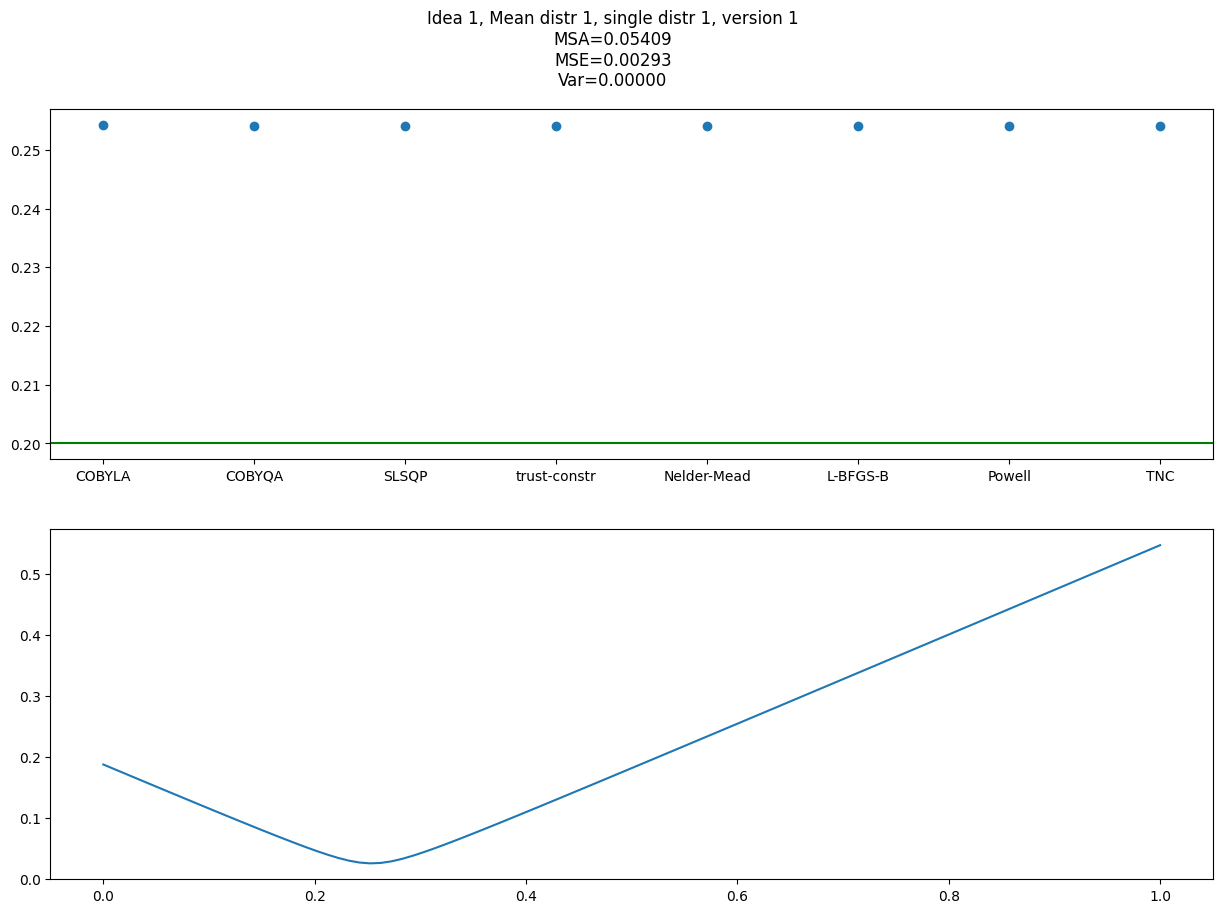

In [124]:
visualize_one_absolute(results=guess1_1_1,
                       A=fA1_1_1,
                       B=fB1_1_1,
                       C=fC1_1_1,
                       algorithms=methods,
                       save=True,
                       idea_num=1,
                       mean_func_num=1,
                       single_func_num=1,
                       version=1
)

### d1.2

In [167]:
guess1_3_1, fA1_3_1, fB1_3_1, fC1_3_1 = get_accuracy_results(
    mean_d_func=mean_distribution1_1,
    single_func=single_distr1_3,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

/tmp/ipykernel_6607/3247681911.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['0']+ algorithms)


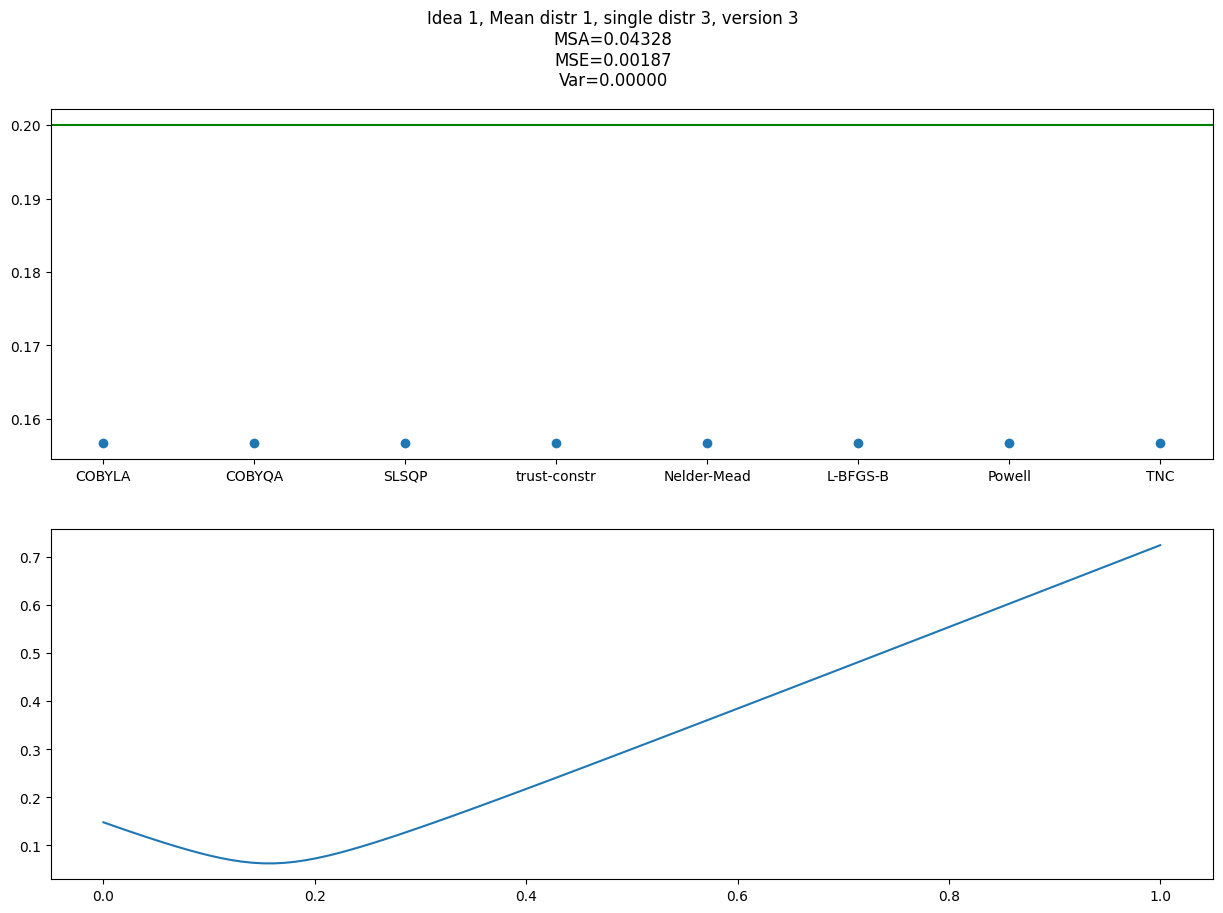

In [168]:
visualize_one_absolute(results=guess1_3_1,
                       A=fA1_3_1,
                       B=fB1_3_1,
                       C=fC1_3_1,
                       algorithms=methods,
                       save=True,
                       idea_num=1,
                       mean_func_num=1,
                       single_func_num=3,
                       version=3
)

In [ ]:
guess1_2_1, fA1_2_1, fB1_2_1, fC1_2_1 = get_accuracy_results(
    mean_d_func=mean_distribution1_1,
    single_func=single_distr1_2,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

/tmp/ipykernel_6607/3247681911.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['0']+ algorithms)


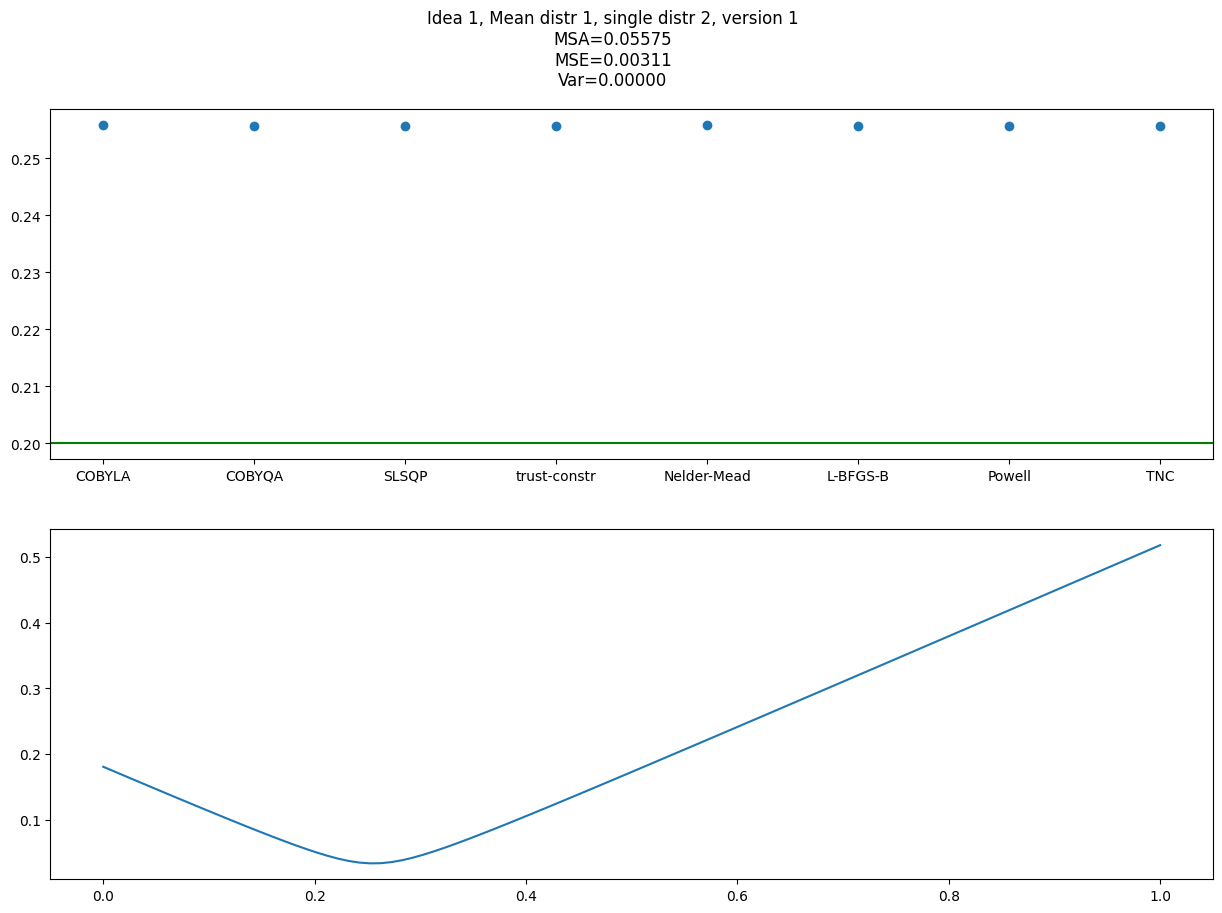

In [125]:
visualize_one_absolute(results=guess1_2_1,
                       A=fA1_2_1,
                       B=fB1_2_1,
                       C=fC1_2_1,
                       algorithms=methods,
                       save=True,
                       idea_num=1,
                       mean_func_num=1,
                       single_func_num=2,
                       version=1
)

In [242]:
res1_2_1 = get_accuracy_test_results(mean_distribution1_1, single_distr1_2)

/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/home/vitalii/Documents/hse/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results ca

In [ ]:
visualize_absolute(res1_2_1, save=True, idea=1, mean_func_num=1, single_func_num=2, version=1)

In [ ]:
visualize_error(res1_2_1, np.array([0.1, 0.05, 0.02, 0.01]), save=True, idea=1, mean_func_num=1, single_func_num=2, version=1)

### d1.3

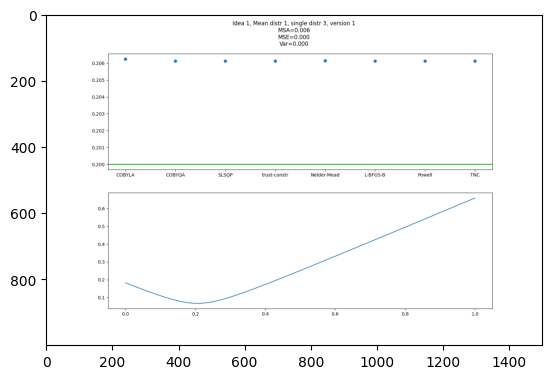

In [156]:
img = mpimg.imread('task6_test_pictures/stats_abs_i1_d3_f1_v1.png')
# plt.set_size_inches((20, 30))
imgplot = plt.imshow(img)
plt.show()

### d1.4

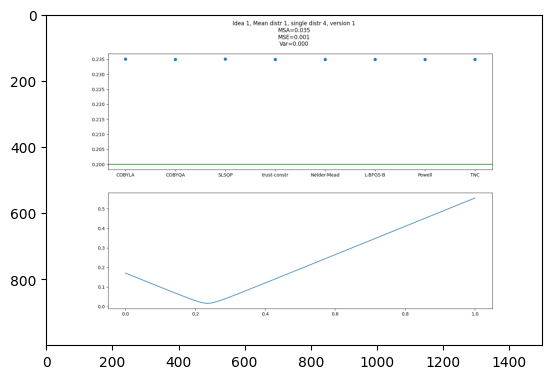

In [157]:
img = mpimg.imread('task6_test_pictures/stats_abs_i1_d4_f1_v1.png')
imgplot = plt.imshow(img)
plt.show()

### d1.5

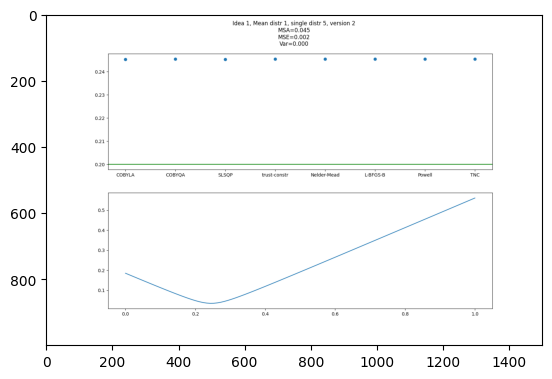

In [158]:
img = mpimg.imread('task6_test_pictures/stats_abs_i1_d5_f1_v2.png')
imgplot = plt.imshow(img)
plt.show()

# Идея 2: векторы длины от числа всех соседей из на ветке ($2 \cdot p \cdot k_r$)

Здесь $|H| = i$

Получается, что длина вектора $4k_r$, и нумерацию начинать надо с $1$, т.к. у любого экземпляра будет хотя бы один сосед.

## Распределение для одного экземпляра

### d2.1. Чистая длина участков

$ \displaystyle d_{el} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t| = i} L^t$ 

In [136]:
def single_distr2_1(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_reference*p*2)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        vector[nearest.size - 1] += tree.span
    vector /= subts.sequence_length
    return vector

### d2.2. Взвешиваем по числу соседей из A

$ \displaystyle d_{el} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t| = i} L^t |H \cap ref_A|$ 

In [132]:
def single_distr2_2(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_reference*p*2)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_reference].size
        vector[nearest.size - 1] += tree.span * refA_neighbours
    vector /= subts.sequence_length
    return vector

### d2.3. Нормируем по доле соседей из A

$ \displaystyle d_{el} [i] = \frac{1}{L} \sum_{t \in \mathbb{T}; |H_{s}^t| = i} L^t \frac{|H \cap ref_A|}{|H|}$

In [159]:
def single_distr2_3(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    vector = np.zeros(k_reference*p*2)
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        nearest_pop = [tree.population(nd) for nd in nearest]
        refA_neighbours = nearest[nearest < p * k_reference].size
        vector[nearest.size - 1] += tree.span * refA_neighbours / nearest.size
    vector /= subts.sequence_length
    return vector

## Распределение популяции

### f2.1 = f1.1

In [137]:
def mean_distribution2_1(treeseq, reference, samples, single_func, p, k_ref):
    """
    Calculate population distribution function as mean of distributions of samples
    """
    vector = np.zeros(k_reference*p*2)
    for el in samples:
        vector += single_func(treeseq, reference, el, p, k_ref)
    vector /= len(samples)
    return vector

## Тестируем

### d2.1

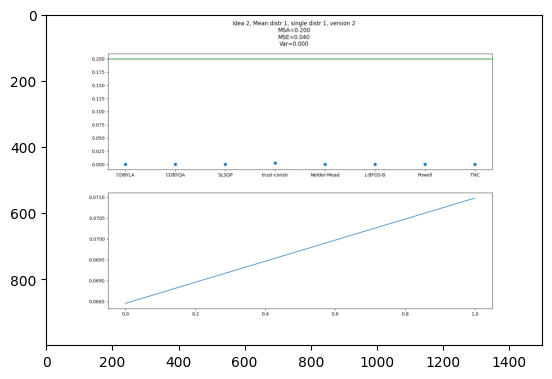

In [160]:
img = mpimg.imread('task6_test_pictures/stats_abs_i2_d1_f1_v2.png')
imgplot = plt.imshow(img)
plt.show()

### d2.2

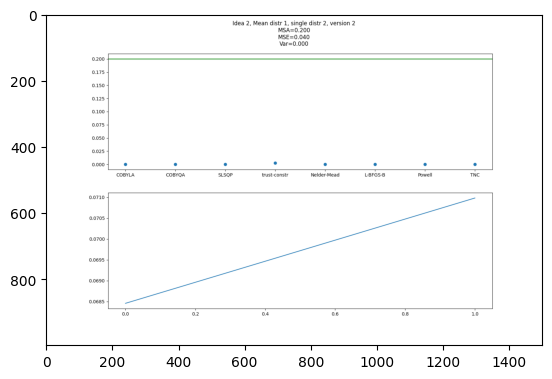

In [161]:
img = mpimg.imread('task6_test_pictures/stats_abs_i2_d2_f1_v2.png')
imgplot = plt.imshow(img)
plt.show()

### d2.2 с усренением с делением на i

In [134]:
guess2_2_2, fA2_2_2, fB2_2_2, fC2_2_2 = get_accuracy_results(
    mean_d_func=mean_distribution2_2,
    single_func=single_distr2_2,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

/tmp/ipykernel_6607/3247681911.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['0']+ algorithms)


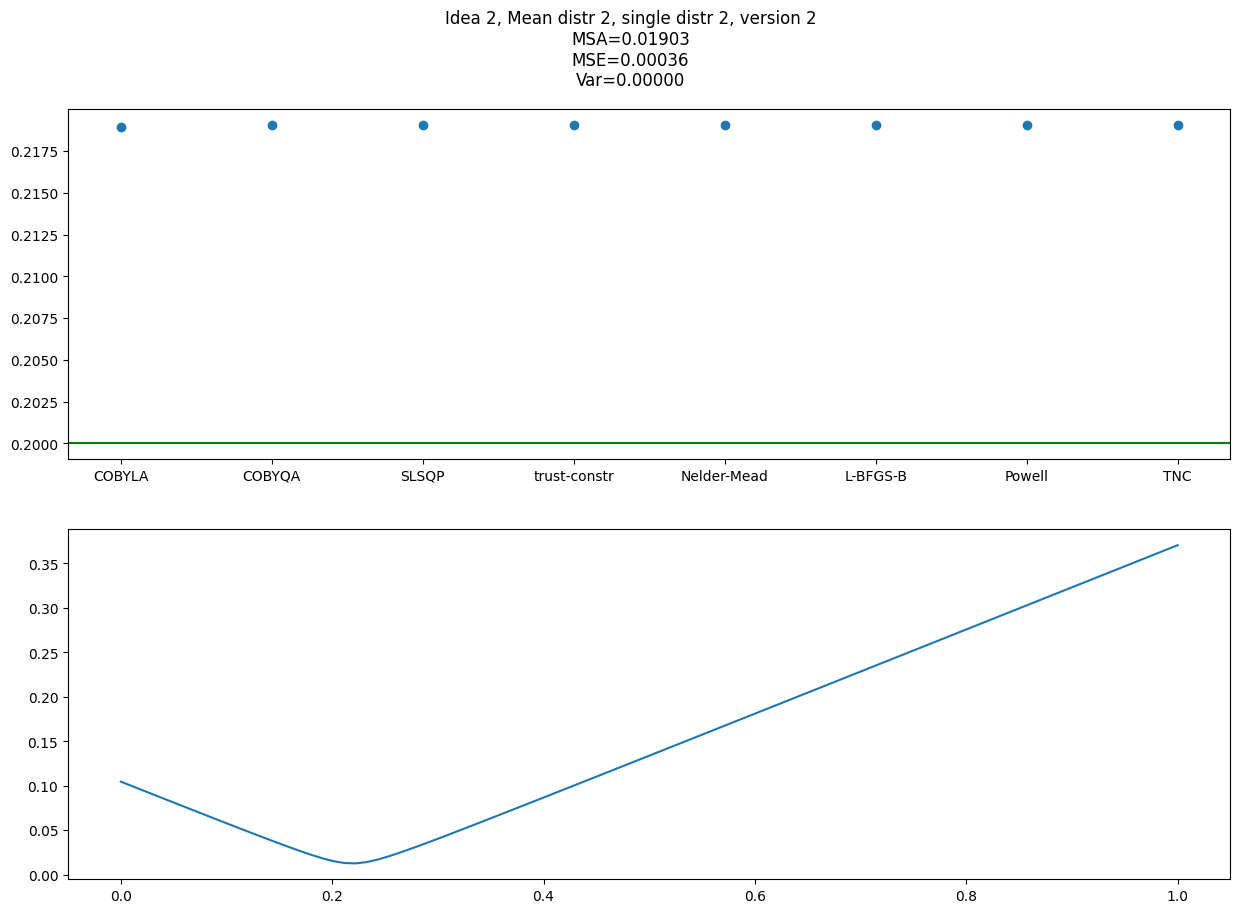

In [135]:
visualize_one_absolute(results=guess2_2_2,
       A=fA2_2_2,
       B=fB2_2_2,
       C=fC2_2_2,
       algorithms=methods,
       save=True,
       idea_num=2,
       mean_func_num=2,
       single_func_num=2,
       version=2
)

### d2.3

In [164]:
guess2_3_1, fA2_3_1, fB2_3_1, fC2_3_1 = get_accuracy_results(
    mean_d_func=mean_distribution2_1,
    single_func=single_distr2_3,
    algorithms=methods,
    k_ref=k_reference,
    k_learn=k_learning,
    k_val=k_validation,
    num_m=m,
    plo=ploidy,
    seq_len=sequence_len,
    rec_rate=recomb_rate,
    repl=replicates,
)

KeyboardInterrupt: 

In [ ]:
visualize_one_absolute(results=guess2_3_1,
       A=fA2_3_1,
       B=fB2_3_1,
       C=fC2_3_1,
       algorithms=methods,
       save=True,
       idea_num=2,
       mean_func_num=1,
       single_func_num=3,
       version=1
)

# Идея 4: Пытаемся перекинуть идею 3 на векторы

Идея 3 была со скалярами, она не вошла в этот ноутбук из-за плохих результатов. По доказанному соображению нам было известно

$\displaystyle l_C = \alpha \cdot l_A + (1-\alpha) \cdot l_B$

Отсюда

$\alpha = \frac{l_C-l_B}{l_A-l_B}$

$l_P$ это "распределение популяции". В тот раз мне показалось [на глаз, без существующий сейчас тестов] достаточно точным такое вычисление:

Для некоторого семпла $s$ назовем средневзешенным числом соседей из популяции $P$ число

$\displaystyle w_{s, P} = \frac{1}{L} \sum_{t \in \mathbb{T}} |H \cap P| \cdot L^t  $

Cредневзешенным числом соседей из популяции $P$ для популяции $Q$ назовем

$\displaystyle W_{Q, P} = \frac{1}{|Q|} \sum_{s \in Q} w_{s, P}  $

Тогда **статистики распределения соседей** [=доля соседей из A] для P = A, B, C насчитываются как 

$l_{P} = \frac{ W_{A, P}}{(W_{A, P} + W_{B, P})}$

Сделаем не скалярное распределение на основе вектора весов, а векторное w_1 / (w_1 + w_2)

Внизу все нули заменяем на 1

Проверим на $2 \cdot p \cdot k_r$-векторах, потому что не совсем понятно пока, как интерпретировать взвешивание кол-во соседей из A в ячейке, индекс которой и значит это самое кол-во.

## Распределение для одного экземпляра

### d4.1 4k

In [130]:
def single_distr4_1(treeseq, reference, sample, p, k_ref):
    subts = get_sub_ARG(treeseq, reference, sample)
    newsample = len(subts.samples()) - 1
    # 0 - для A, 1 - для B
    vector = np.zeros((2, 2*p*k_ref))
    for tree in subts.trees():
        siblings = tree.siblings(newsample)
        nearest = [[leaf for leaf in tree.leaves(sibling)] for sibling in siblings][0]
        if newsample in nearest:
            nearest.remove(newsample)
        nearest = np.array(nearest)
        # nearest_pop = [tree.population(nd) for nd in nearest]        
        neighbours = nearest.size
        refA_neighbours = nearest[nearest < p * k_ref].size
        refB_neighbours = nearest[(2 * k_ref <= nearest) & (nearest < 2*p * k_ref)].size
        vector[0, neighbours-1] += tree.span * refA_neighbours
        vector[1, neighbours-1] += tree.span * refB_neighbours
    vector /= subts.sequence_length
    return vector

## Распределение для популяции

### f4.1

In [131]:
def mean_distribution4_1(treeseq, reference, samples, single_func, p, k_ref):
    vec = np.zeros((2, 2*p*k_ref))
    for el in samples:
        vec += single_func(treeseq, reference, el, k_ref)
    vec /= samples.size
    num = vec[0]
    denom = np.sum(vec, axis=0)
    # чтобы не разделить на 0
    denom[denom == 0] = 1
    return num / denom

## Тестируем

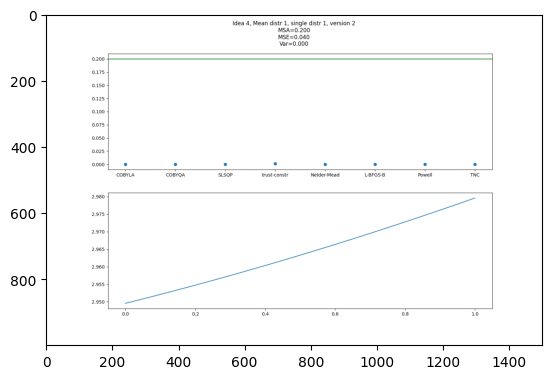

In [162]:
img = mpimg.imread('task6_test_pictures/stats_abs_i4_d1_f1_v2.png')
imgplot = plt.imshow(img)
plt.show()

# Пробуем ускорить конкурентным запуском (работает еще дольше)

In [146]:
import concurrent.futures
def worker_1_3_1(seed):
    smp = {"A": k_reference + k_learning, "B": k_reference + k_learning}
    for i in range(1, m+1):
        smp[f"C{i}"] = k_validation
        
    ARG = msprime.sim_ancestry(
        ploidy=plo,
        samples=smp,
        demography=dem,
        sequence_length=sequence_len,
        recombination_rate=recomb_rate,
        random_seed=seed
    )

    reference, learnA, learnB, validation_sets = arg_sets(ARG, plo, k_reference, k_learning, m)
    A = mean_distribution1_1(treeseq, reference, learnA, single_distr1_3, plo, k_reference)
    B = mean_distribution1_1(treeseq, reference, learnB, single_distr1_3, plo, k_reference)
    C = mean_distribution1_1(treeseq, reference, validation_sets[0], single_distr1_3, plo, k_reference)
    return np.array([minimize(target_func, x0=start_guess, args=(A, B, C), method=algo, bounds=bnd).x[0] for algo in methods])

In [ ]:
rng = np.random.RandomState(42)
seeds = rng.randint(1, 2**31, size=replicates)

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(worker_1_3_1, seeds)
    S = np.array(list(results))

# На подумать

1) Мы не юзаем нигде референсы B

2) record_full_arg (bool) – If True, record all intermediate nodes arising from common ancestor and recombination events in the output tree sequence. This will result in unary nodes (i.e., nodes in marginal trees that have only one child). Defaults to False. See the Ancestral recombination graph section for examples.

3) Надо что-то посмотреть с мат ожиданием числа соседей и учитывать это при нормировании аккуратнее.

4) "при условии, что на ветке $i$ референсов" - нормировать тогда надо не по всему $L$, а по сумме длин деревьев, на которых $i$ референсов из $A$ 

5) Может быть как-то обучаться на референсах тоже?

6) Когда 0 референсных особей (идея 2) это грустно, портит ли это стату?

7) А какие еще данные топологического анализа нам могут помочь, помимо длины ветки?

https://tskit.dev/tskit/docs/stable/topological-analysis.html#sec-combinatorics

https://tskit.dev/tutorials/analysing_trees.html#sec-analysing-trees

https://tskit.dev/tutorials/counting_topologies.html#sec-counting-topologies

https://tskit.dev/tutorials/popgen.html

Взвешивать по "расстоянию" в ребрах?

### [Not implemented] d1.4. Нормируем по числу соседей из A для данной ветки